In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.utils import resample
from sklearn.model_selection import ParameterGrid
import seaborn as sns

In [2]:
# ==== Load and Prepare Data ====
samples = pd.read_csv(r'D:\Nam3\HK2\ATBM\DDOS\Dataset\export_dataframe_proc.csv')
tests = pd.read_csv(r'D:\Nam3\HK2\ATBM\DDOS\Dataset\export_tests_proc.csv')

X_train = samples.iloc[:, :-1]
y_train = samples.iloc[:, -1]
X_test = tests.iloc[:, :-1]
y_test = tests.iloc[:, -1]

# ==== Upsample ====
df = pd.concat([X_train, y_train], axis=1)
normal = df[df['Label'] == 0]
ddos = df[df['Label'] == 1]
normal_upsampled = resample(normal, replace=True, n_samples=len(ddos), random_state=27)
upsampled = pd.concat([normal_upsampled, ddos])
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]

# ==== Normalize ====
scaler = MinMaxScaler((-1, 1)).fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [3]:
# ==== Evaluation Function ====
def evaluate_model(model, X_train, y_train, X_test, y_test, params):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    cm = confusion_matrix(y_test, y_pred)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]
    FP = cm[0, 1]

    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0),
        'Normal_Detect_Rate': TN / (TN + FP + 1e-9),
        'Atk_Detect_Rate': TP / (TP + FN + 1e-9),
        'Training_Time': train_time,
        'Confusion_Matrix': cm.tolist(),
        'ROC_FPR': fpr.tolist(),
        'ROC_TPR': tpr.tolist(),
        'ROC_AUC': roc_auc,
        **params
    }

# ==== Grid Search Parameters ====
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

results = []
for params in ParameterGrid(param_grid):
    print(f"Training KNN with {params}")
    model = KNeighborsClassifier(**params)
    result = evaluate_model(model, X_train, y_train, X_test, y_test, params)
    results.append(result)

Training KNN with {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Training KNN with {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Training KNN with {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Training KNN with {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Training KNN with {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
Training KNN with {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Training KNN with {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
Training KNN with {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Training KNN with {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
Training KNN with {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Training KNN with {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Training KNN with {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}


In [4]:
# ==== Save All Results ====
df_results_knn = pd.DataFrame([
    {k: v for k, v in res.items() if k not in ['ROC_FPR', 'ROC_TPR']} for res in results
])
df_results_knn.to_csv('knn_gridsearch_results.csv', index=False)

# ==== Save Best Result ====
best_index = df_results_knn['Accuracy'].idxmax()
best_model_result = results[best_index]
best_model_df = pd.DataFrame([{
    k: v for k, v in best_model_result.items() if k not in ['ROC_FPR', 'ROC_TPR']
}])
print("\nBest Hyperparameters (KNN - Highest Accuracy):")
for param in best_model_df.columns:
    print(f"{param}: {best_model_df[param][0]}")
best_model_df.to_csv('knn_best_result.csv', index=False)

# ==== Save ROC ====
np.save('knn_best_roc_fpr.npy', np.array(best_model_result['ROC_FPR']))
np.save('knn_best_roc_tpr.npy', np.array(best_model_result['ROC_TPR']))
np.save('knn_best_roc_auc.npy', best_model_result['ROC_AUC'])


Best Hyperparameters (KNN - Highest Accuracy):
Accuracy: 0.9990871587817081
Precision: 0.9995926179564172
Recall: 0.9993118581585184
F1-Score: 0.9994522183401513
Normal_Detect_Rate: 0.997963661897639
Atk_Detect_Rate: 0.9993118581585149
Training_Time: 0.12937235832214355
Confusion_Matrix: [[56849, 116], [196, 284629]]
ROC_AUC: 0.9988423791045591
metric: manhattan
n_neighbors: 3
weights: distance


In [37]:
grid_df = pd.read_csv(r"knn_gridsearch_results.csv")

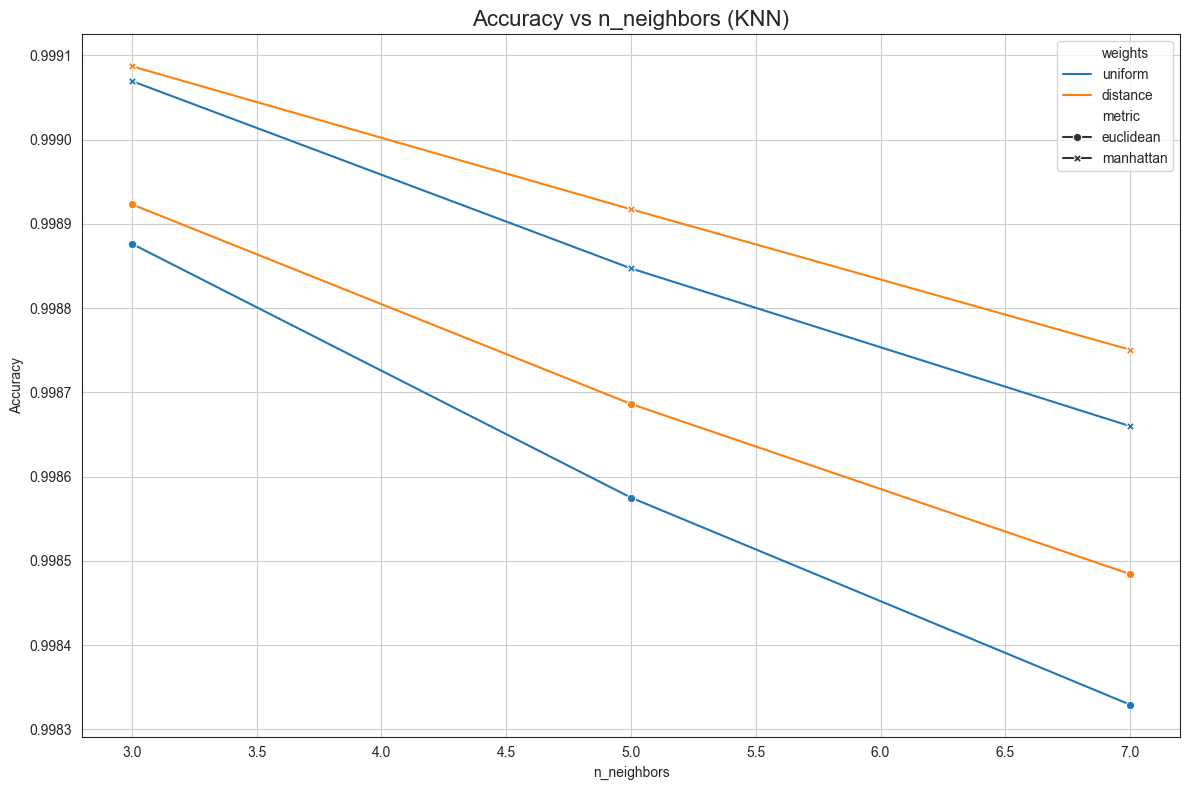

In [39]:
plt.figure(figsize=(12, 8))

# Accuracy vs n_neighbors, grouped by weights, styled by metric
sns.lineplot(
    data=grid_df,
    x='n_neighbors',
    y='Accuracy',
    hue='weights',
    style='metric',
    markers=True,
    dashes=False,
    palette='tab10',
    errorbar=None
)

plt.title("Accuracy vs n_neighbors (KNN)", fontsize=16)
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

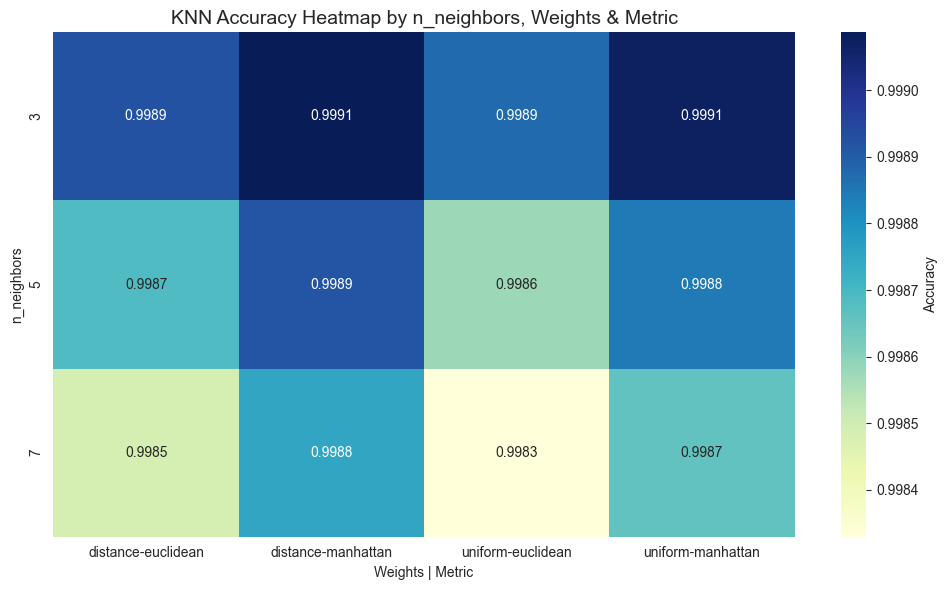

In [40]:
# Convert to string for multi-level column labeling
grid_df['weights'] = grid_df['weights'].astype(str)
grid_df['metric'] = grid_df['metric'].astype(str)

# Create pivot table: rows = n_neighbors, columns = (weights, metric), values = Accuracy
heatmap_data = grid_df.pivot_table(
    index='n_neighbors',
    columns=['weights', 'metric'],
    values='Accuracy',
    aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,          # Show accuracy values
    fmt=".4f",           # Format to 4 decimal places
    cmap="YlGnBu",       # Color map
    cbar_kws={'label': 'Accuracy'}  # Color bar label
)

# Add labels and title
plt.title("KNN Accuracy Heatmap by n_neighbors, Weights & Metric", fontsize=14)
plt.xlabel("Weights | Metric")
plt.ylabel("n_neighbors")
plt.tight_layout()
plt.show()

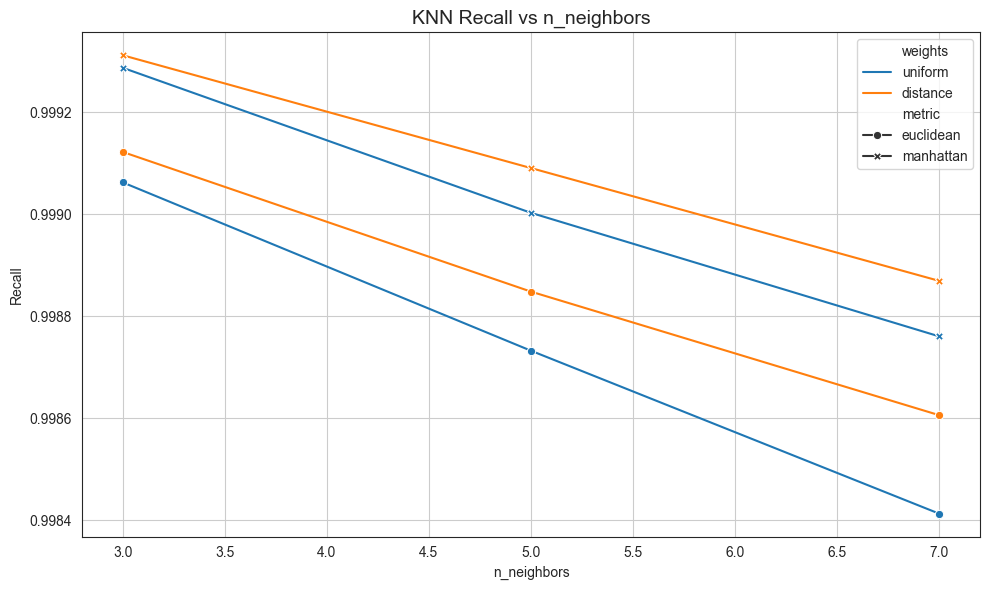

In [43]:
plt.figure(figsize=(10, 6))

# Plot Recall vs n_neighbors, grouped by weights, styled by metric
sns.lineplot(
    data=grid_df,
    x='n_neighbors',
    y='Recall',
    hue='weights',
    style='metric',
    markers=True,
    dashes=False,
    palette='tab10',
    errorbar=None
)

# Add title and axis labels
plt.title("KNN Recall vs n_neighbors", fontsize=14)
plt.xlabel("n_neighbors")
plt.ylabel("Recall")
plt.grid(True)
plt.tight_layout()
plt.show()

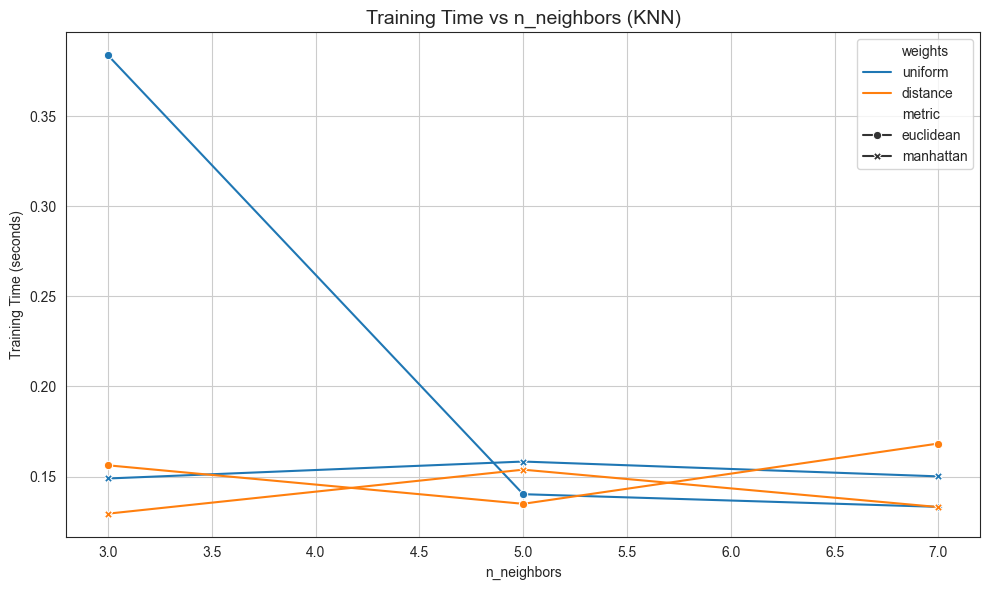

In [48]:
plt.figure(figsize=(10, 6))

# Plot Training Time vs n_neighbors, grouped by weights, styled by metric
sns.lineplot(
    data=grid_df,
    x='n_neighbors',
    y='Training_Time',
    hue='weights',
    style='metric',
    markers=True,
    dashes=False,
    palette='tab10',
    errorbar=None
)

# Add title and axis labels
plt.title("Training Time vs n_neighbors (KNN)", fontsize=14)
plt.xlabel("n_neighbors")
plt.ylabel("Training Time (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
best_model = grid_df.loc[grid_df['Accuracy'].idxmax()]
print("Best Model Parameters:")
print(best_model)

Best Model Parameters:
Accuracy                                   0.999087
Precision                                  0.999593
Recall                                     0.999312
F1-Score                                   0.999452
Normal_Detect_Rate                         0.997964
Atk_Detect_Rate                            0.999312
Training_Time                              0.129372
Confusion_Matrix      [[56849, 116], [196, 284629]]
ROC_AUC                                    0.998842
metric                                    manhattan
n_neighbors                                       3
weights                                    distance
Name: 7, dtype: object


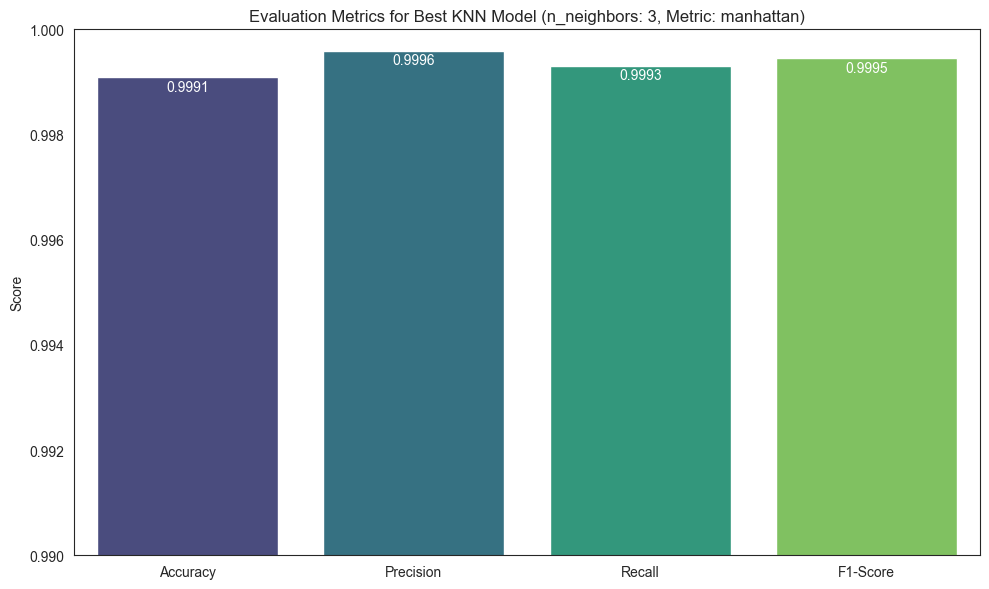

In [36]:
# Prepare evaluation metrics for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [best_model['Accuracy'], best_model['Precision'], best_model['Recall'], best_model['F1-Score']]

# Plot the evaluation metrics as a barplot with 'hue' assigned to 'metrics'
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values, hue=metrics, palette='viridis', legend=False)

# Add labels inside the bars, closer to the top
for i, value in enumerate(values):
    plt.text(i, value - 0.00005, f'{value:.4f}', ha='center', va='top', color='white')

# Set the y-axis to start from 0.99
plt.ylim(0.99, 1.0)  # Adjust this range as needed

# Add plot title and labels
plt.title(f"Evaluation Metrics for Best KNN Model (n_neighbors: {best_model['n_neighbors']}, Metric: {best_model['metric']})")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

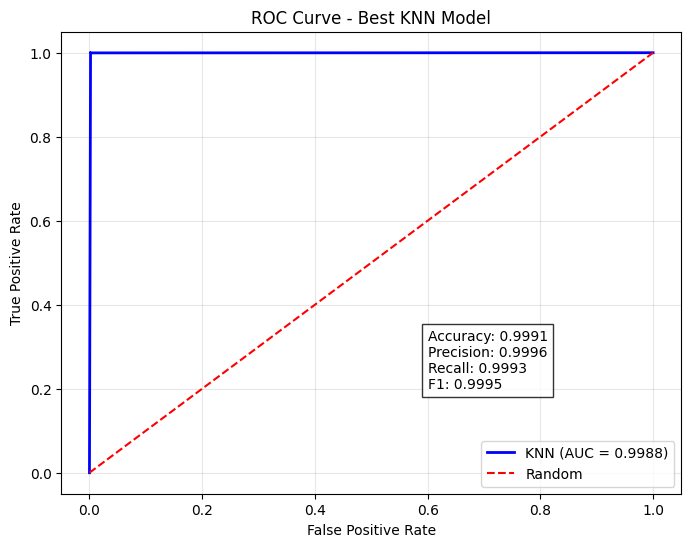

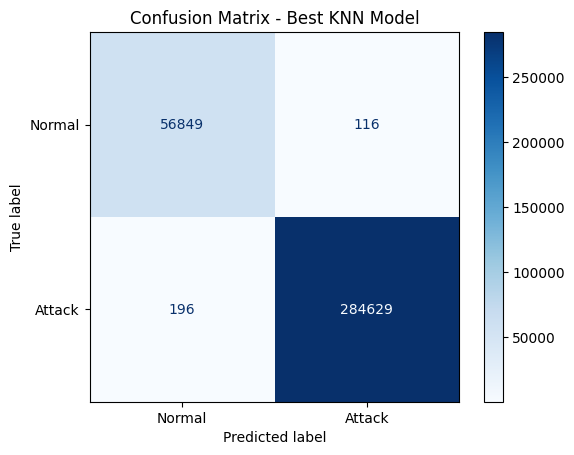

In [ ]:
# ==== Plot ROC ====
fpr = np.load('knn_best_roc_fpr.npy', allow_pickle=True)
tpr = np.load('knn_best_roc_tpr.npy', allow_pickle=True)
roc_auc = np.load('knn_best_roc_auc.npy', allow_pickle=True)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'KNN (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best KNN Model')
plt.legend()
plt.grid(alpha=0.3)

# Annotate metrics
plt.text(0.6, 0.2, f'Accuracy: {best_model_df["Accuracy"].values[0]:.4f}\n'
                   f'Precision: {best_model_df["Precision"].values[0]:.4f}\n'
                   f'Recall: {best_model_df["Recall"].values[0]:.4f}\n'
                   f'F1: {best_model_df["F1-Score"].values[0]:.4f}',
         bbox=dict(facecolor='white', alpha=0.8))
plt.show()

# ==== Plot Confusion Matrix ====
cm = np.array(best_model_result['Confusion_Matrix'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Best KNN Model')
plt.grid(False)
plt.show()